In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from astropy.nddata import Cutout2D
import gc
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u
import os
from multiprocessing import get_context
from src.filter_worker import process_rubin_filter, process_euclid_filter
from src.gaap_analysis import calculate_gaap_flux, find_noise_square, prepare_wiener_psf, estimate_sigma, padded_cutout_with_center, create_psf, gaussian_2d, gaussian_weight, wiener_deconvolution_fast

In [3]:
mer_catalog = {'53.0_-28.0': 'EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits',
               '58.9_-48.6': 'EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits'}

In [4]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '58.9_-48.6'

#
N_cores = os.cpu_count()

In [5]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/{mer_catalog[field]}', memmap=True) as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/58.9_-48.6/EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1460   111511R x 469C   [K, D, D, D, D, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E

In [10]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file, memmap=True) as hdul:
    hdu = hdul[1]
    image = hdu.data
    wcs = WCS(hdu.header)
    print(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
pixel_scales = proj_plane_pixel_scales(wcs) * u.deg 
print("Pixel scales:", pixel_scales)
pixel_scales_arcsec = pixel_scales.to(u.arcsec)
pixel_scale_rubin = pixel_scales_arcsec.mean().value
print("Mean pixel scale (arcsec/pixel):", pixel_scale_rubin)

XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 3400 / length of data axis 1                          NAXIS2  =                 3400 / length of data axis 2                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     WCSAXES =                    2 / Number of WCS axes                             CRPIX1  =               -2800. / Reference pixel on axis 1                      CRPIX2  =                6200. / Reference pixel on axis 2                      CRVAL1  =     59.2682926829268 / Value at ref. pixel on axis 1                  CRVAL2  =    -48.3471074380165 / Value at ref. pixel on axis 2                  CTYPE1  = 'RA---TAN'           / Type of

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                19200                                                  NAXIS2  =                19200                                                  EQUINOX =        2000.00000000 / Mean equinox                                   RADESYS = 'ICRS    '           / Astrometric system                             CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              CUNIT1  = 'deg     '           / Axis unit                                      CRVAL1  =   5.903182370000E+01 / World coordinate on this axis                  CRPIX1  =                 9600 / Reference pixel on this axis                   CD1_1   =  -2.777777777778E-05 / Linear projection matrix                       CD1_2   =   0.000000000000E+00 / Linear 

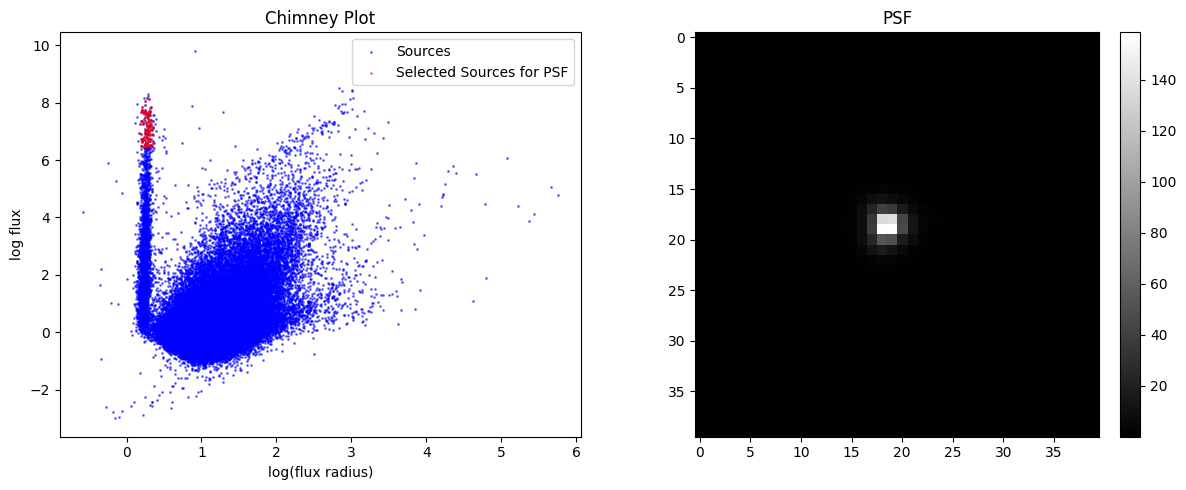

In [9]:
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file, memmap=True) as hdul:
    hdu = hdul[0]
    image = hdu.data
    wcs = WCS(hdu.header)
    print(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
pixel_scales = proj_plane_pixel_scales(wcs) * u.deg 
print("Pixel scales:", pixel_scales)
pixel_scales_arcsec = pixel_scales.to(u.arcsec)
pixel_scale_euclid = pixel_scales_arcsec.mean().value
print("Mean pixel scale (arcsec/pixel):", pixel_scale_euclid)
x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)
catalog = Table.read(f'{location}/{field}/VIS.cat', format="fits", hdu=2)
psf = create_psf(image, catalog, 40, plot_chimney=True, plot_psf=True, window_size=0.05, lower_percentile=95)

In [52]:
original_sizes = np.linspace(2, 30, 30)
size = 64
psf_cache = prepare_wiener_psf(psf, [size, size], K=0)
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    weight = gaussian_weight(size, size, size / 2, size / 2, original_size)
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = original_size

    initial_guess = [amplitude_guess, sigma_guess, x0_guess, y0_guess]

    popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
    amplitude, weight_sigma, x0, y0 = popt
    weight_sigmas[i] = weight_sigma

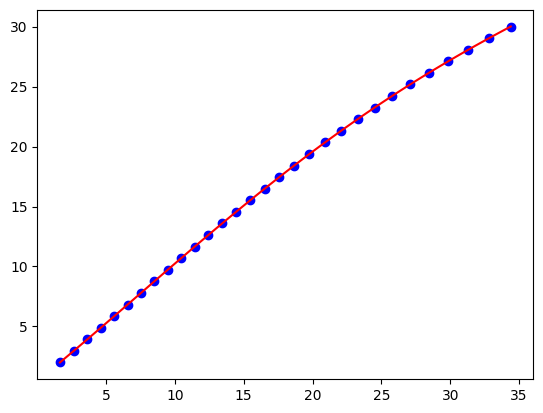

In [53]:
n = 4
coeffs = np.polyfit(np.abs(weight_sigmas[~np.isnan(weight_sigmas)]), original_sizes[~np.isnan(weight_sigmas)], n)
f = Polynomial(coeffs[::-1])  # reverse order

# Evaluate
x_new = np.linspace(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)), 100)
y_fit = f(x_new)
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(x_new, y_fit, color='red')
plt.show()

In [54]:
amplitude_guess = np.mean(image[:3400, :3400])
sigma_guess = 2
initial_guess = [amplitude_guess, sigma_guess]

In [55]:
size = 60
aperture_size = np.full(len(x_c), np.nan)
for i, (x_center, y_center) in enumerate(zip(x_c, y_c)):
    x0 = int(round(x_center))
    y0 = int(round(y_center))

    # bounds (clip to image)
    x_min = max(0, x0 - size//2)
    x_max = min(nx, x0 + size//2 + 1)
    y_min = max(0, y0 - size//2)
    y_max = min(ny, y0 + size//2 + 1)

    cutout = image[y_min:y_max, x_min:x_max]

    x_center_cutout = x_center - x_min
    y_center_cutout = y_center - y_min

    # local coordinate grid
    y, x = np.mgrid[y_min:y_max, x_min:x_max]
    # plt.imshow(cutout)
    # plt.scatter(x_center_cutout, y_center_cutout, c='r')
    # plt.show()
    # break
    # fit only the cutout
    try:
        popt, _ = curve_fit(
            lambda xy, A, s: gaussian_2d(xy, A, s, x_center, y_center),
            (x, y),
            cutout.ravel(),
            p0=initial_guess
        )
        aperture_size[i] = f(np.abs(popt[1])) * pixel_scale_euclid
        if i % 5000 == 0:
            print(i)
            # plt.imshow(cutout)
            # plt.plot([x_center_cutout, x_center_cutout+np.abs(popt[1])], [y_center_cutout, y_center_cutout+np.abs(popt[1])], c='r')
            # plt.show()
            gc.collect()
    except RuntimeError:
        aperture_size[i] = np.inf

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000


In [56]:
fluxes = {}

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference
rubin_filters = ['u', 'g', 'r', 'i', 'z', 'y']
euclid_filters = ['VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
for filter in rubin_filters:
    fluxes[f'flux_{filter}'] = np.full_like(ra_reference, np.nan)
    fluxes[f'flux_{filter}_sigma'] = np.full_like(ra_reference, np.nan)

for filter in euclid_filters:
    fluxes[f'flux_{filter}'] = np.full_like(ra_reference, np.nan)
    fluxes[f'flux_{filter}_sigma'] = np.full_like(ra_reference, np.nan)

In [57]:
def acf(image):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)
    return ac_norm / np.max(ac_norm)

def radial_profile(acf):
    y, x = np.indices(acf.shape)
    cy, cx = np.array(acf.shape) // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)

    tbin = np.bincount(r.ravel(), acf.ravel())
    nr = np.bincount(r.ravel())
    return tbin / nr

Processing filter: u


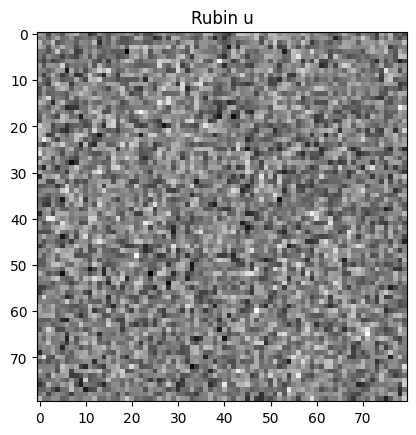

Processing filter: g


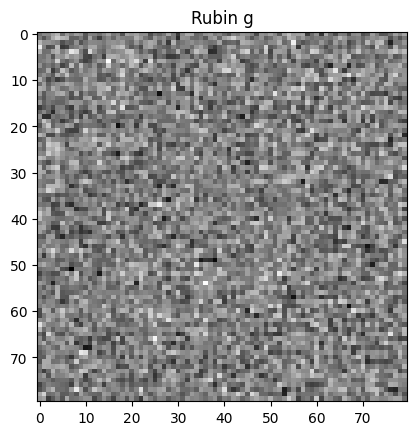

Processing filter: r


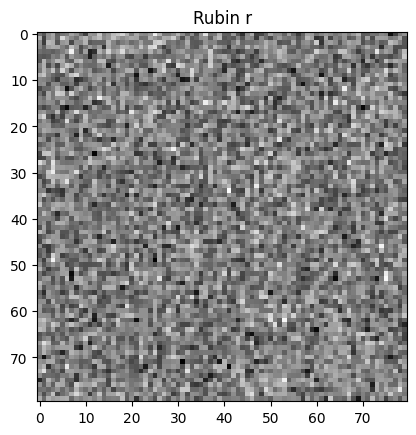

Processing filter: i


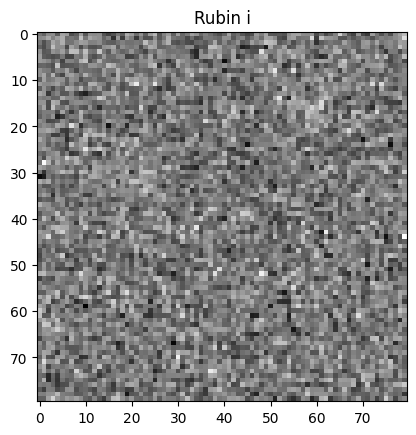

Processing filter: z


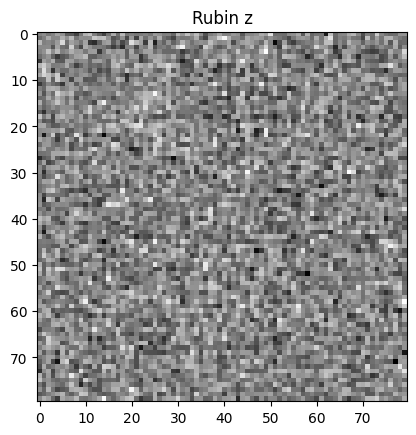

Processing filter: y


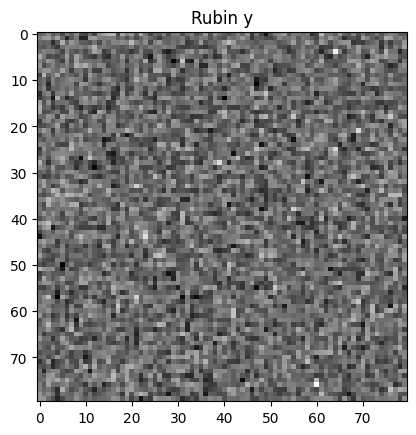

Processing filter: VIS


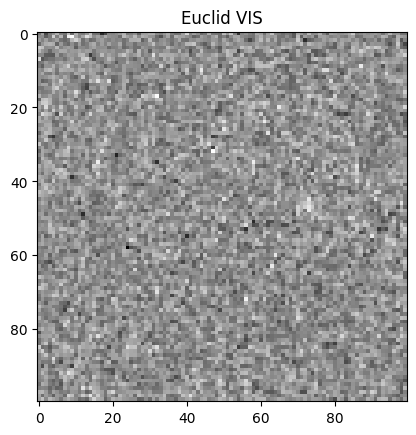

Processing filter: DES-G


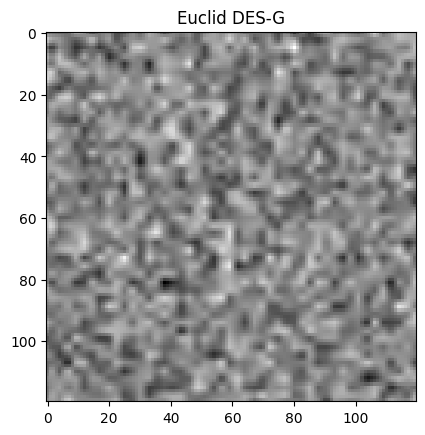

Processing filter: DES-R


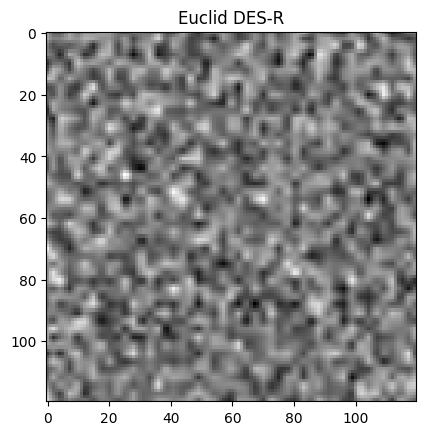

Processing filter: DES-I


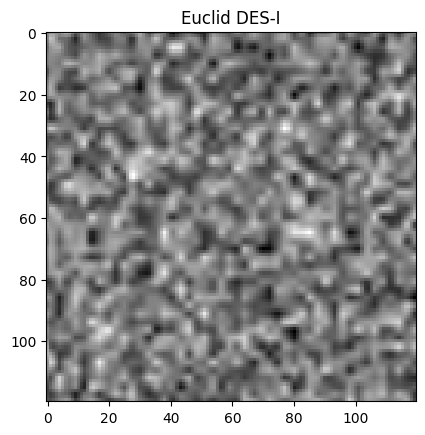

Processing filter: NIR-Y


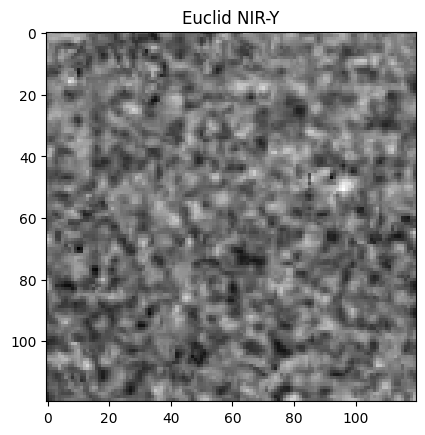

Processing filter: NIR-J


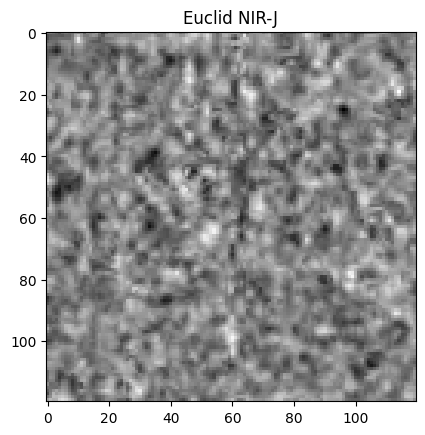

Processing filter: NIR-H


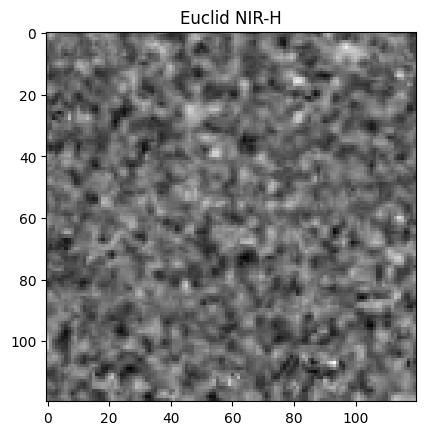

In [58]:
covariance_threshold = 0.01
noise_squares = {}
maxlag = {}

for filter in rubin_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[1]
        image = hdu.data

    noise_cutout = find_noise_square(image, 80)
    plt.imshow(noise_cutout, cmap='gray')
    plt.title(f'Rubin {filter}')
    plt.show()
    noise_squares[filter] = noise_cutout
    covariance = acf(noise_cutout)
    covariance_r = radial_profile(covariance)
    r_corr = np.where(np.abs(covariance_r) < covariance_threshold)[0][0]
    maxlag[filter] = r_corr
    gc.collect()


for filter in euclid_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[0]
        image = hdu.data
        zeropoint = hdu.header["MAGZERO"]
        conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 10**9

    if filter == 'VIS':
        noise_cutout = find_noise_square(image[:4000, :4000], 100) * conversion_factor
    
    else:
        noise_cutout = find_noise_square(image[:4000, :4000], 120) * conversion_factor
    plt.imshow(noise_cutout, cmap='gray')
    plt.title(f'Euclid {filter}')
    plt.show()
    noise_squares[filter] = noise_cutout
    covariance = acf(noise_cutout)
    covariance_r = radial_profile(covariance)
    r_corr = np.where(np.abs(covariance_r) < covariance_threshold)[0][0]
    maxlag[filter] = r_corr
    gc.collect()

In [59]:
print(maxlag)

{'u': np.int64(2), 'g': np.int64(2), 'r': np.int64(2), 'i': np.int64(2), 'z': np.int64(2), 'y': np.int64(2), 'VIS': np.int64(2), 'DES-G': np.int64(7), 'DES-R': np.int64(4), 'DES-I': np.int64(5), 'NIR-Y': np.int64(26), 'NIR-J': np.int64(7), 'NIR-H': np.int64(5)}


Processing filter: u
Processing filter: g
Processing filter: r
Processing filter: i
Processing filter: z
Processing filter: y
Processing filter: VIS


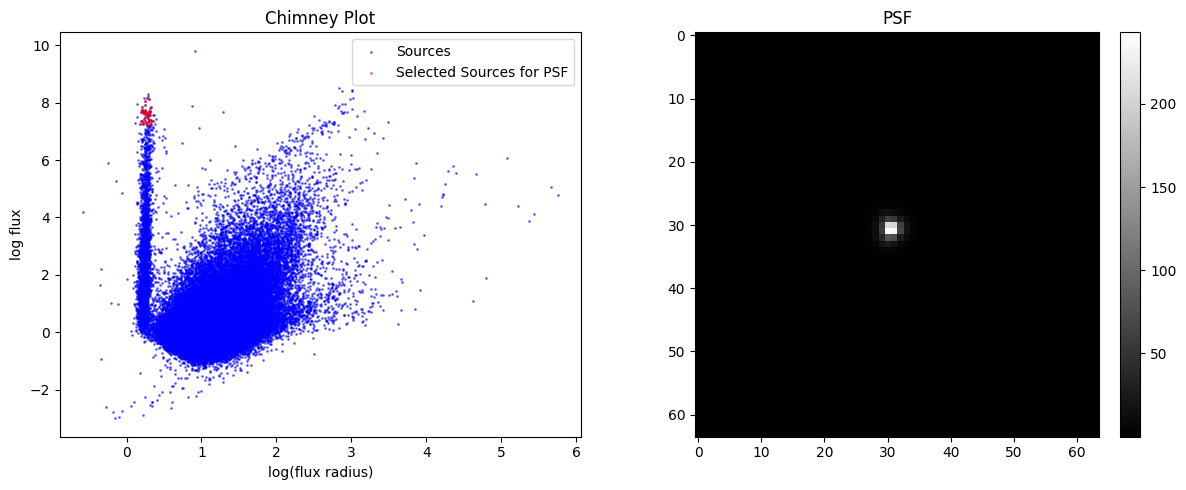

Processing filter: DES-G


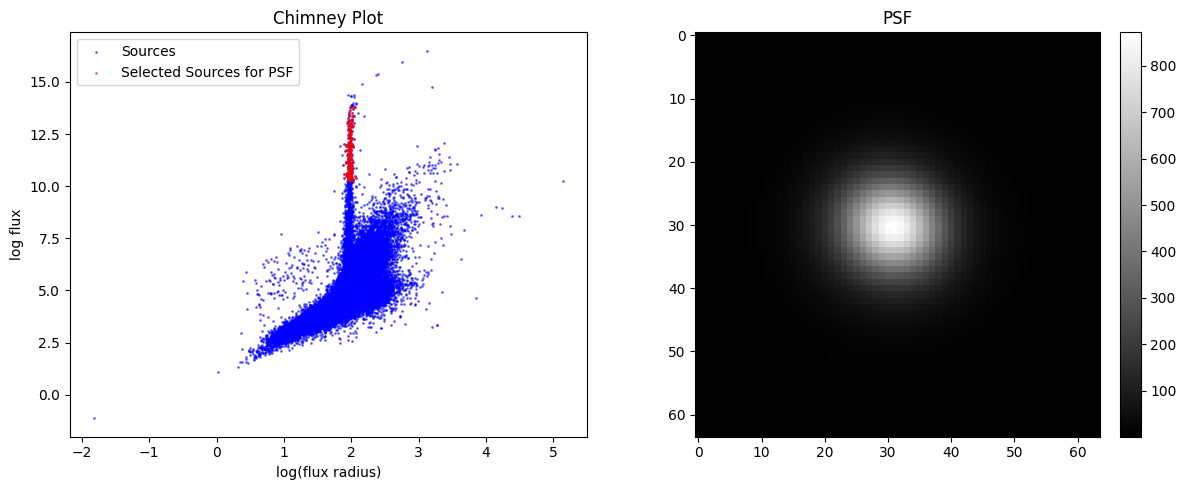

Processing filter: DES-R


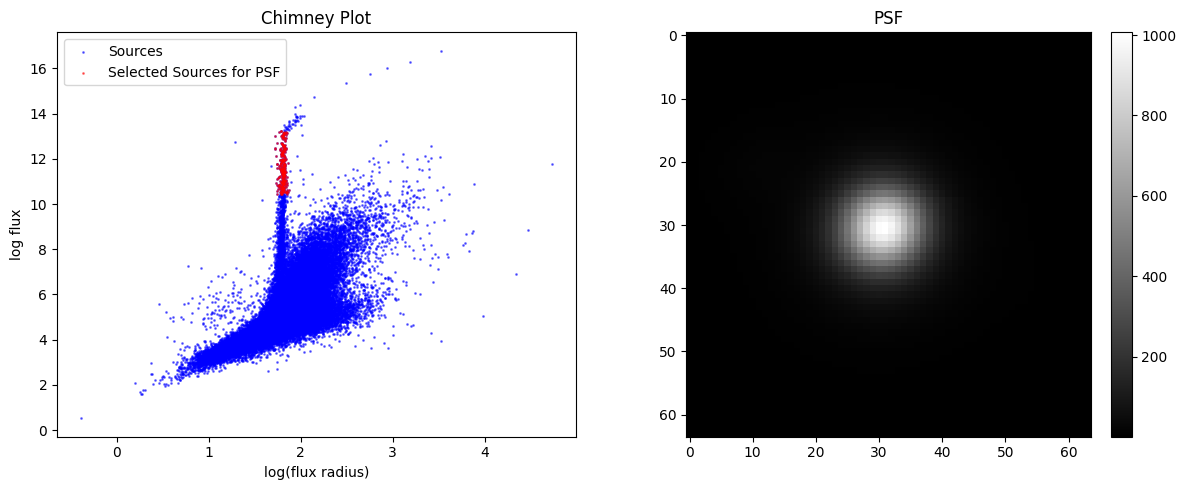

Processing filter: DES-I


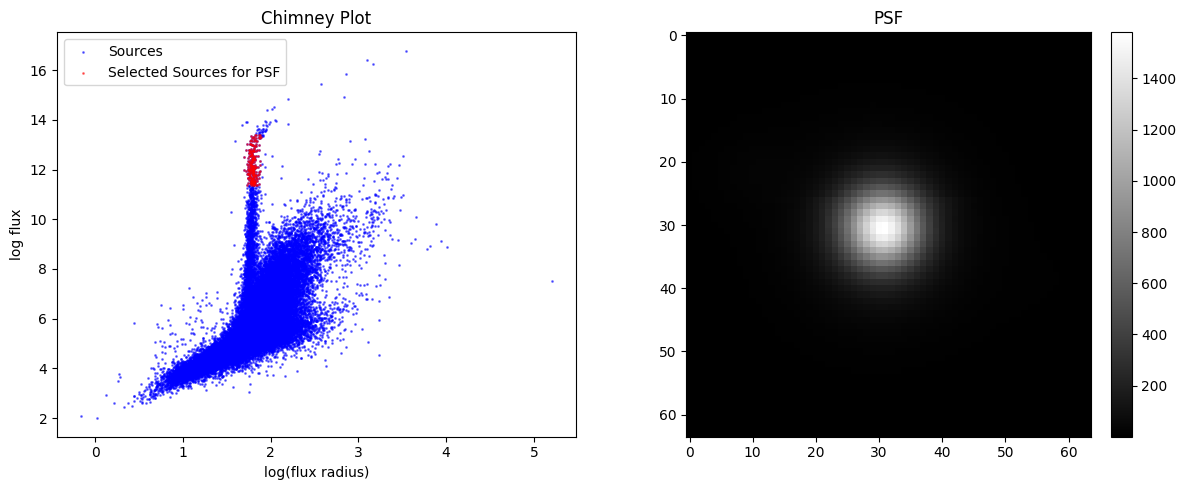

Processing filter: NIR-Y


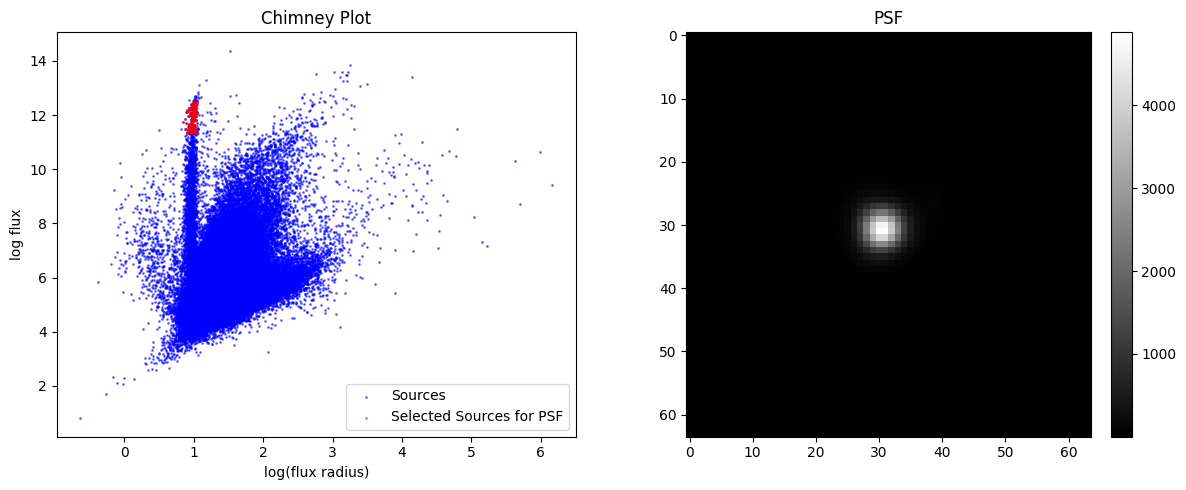

Processing filter: NIR-J


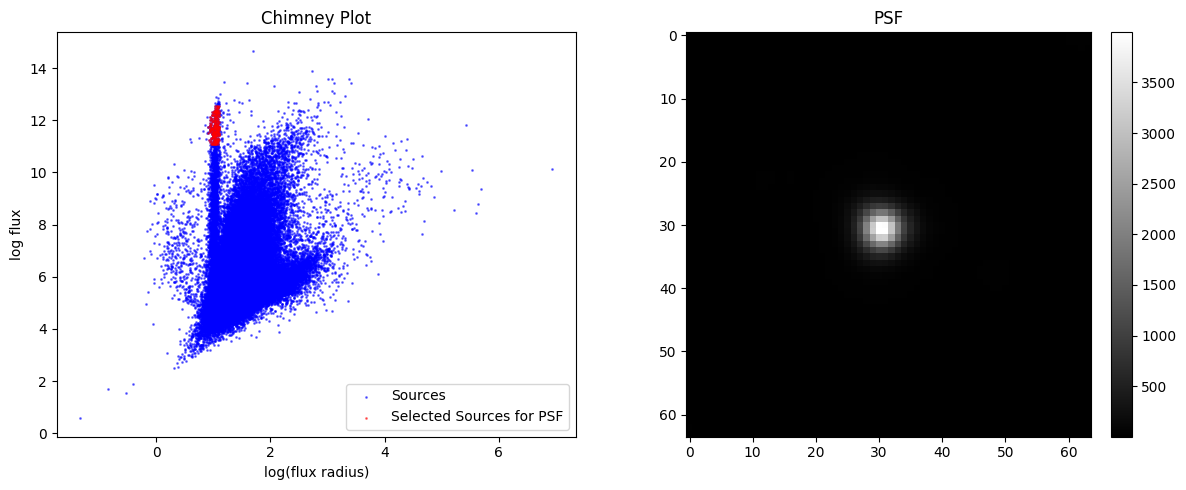

Processing filter: NIR-H


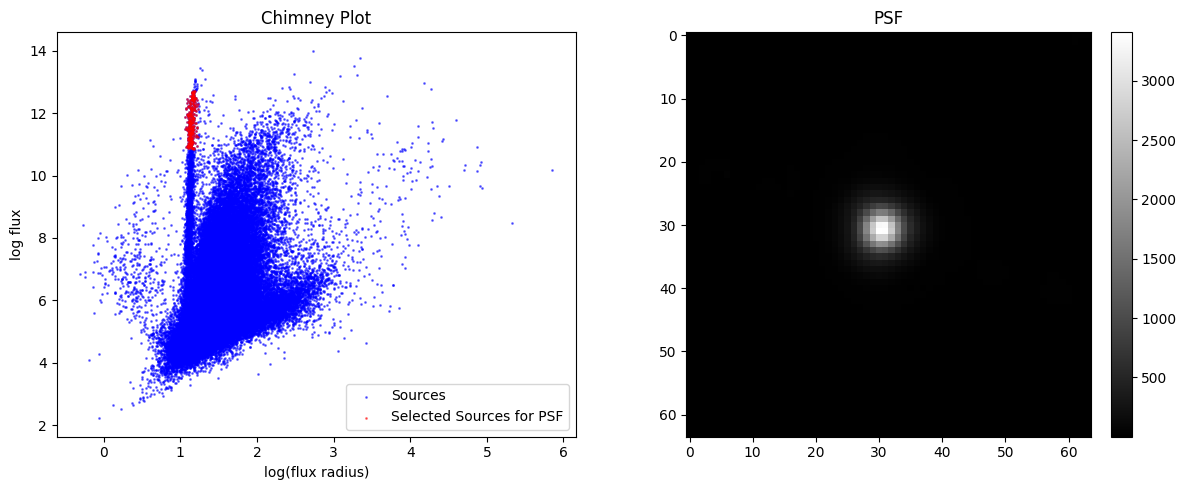

In [ ]:
psfs = {}
psf_sizes = {}
for filter in rubin_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    psf_file = [f for f in files if f.endswith("psf.fits")][0]
    with fits.open(psf_file) as hdul:
        psf = hdul[0].data
    psfs[filter] = psf

    y, x = np.mgrid[0:psf.shape[0], 0:psf.shape[0]]
    initial_guess = [np.max(psf), 4]
    popt, _ = curve_fit(
        lambda xy, A, s: gaussian_2d(xy, A, s, psf.shape[0] * 0.5, psf.shape[0] * 0.5),
        (x, y),
        psf.ravel(),
        p0=initial_guess
    )
    psf_sizes[filter] = np.abs(popt[1]) * pixel_scale_rubin


psf_size = 64
for filter in euclid_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[0]
        image = hdu.data

    catalog = Table.read(f'{location}/{field}/{filter}.cat', format="fits", hdu=2)
    psf = create_psf(image, catalog, psf_size, plot_psf=True, plot_chimney=True, window_size=0.05)
    psfs[filter] = psf
    y, x = np.mgrid[0:psf.shape[0], 0:psf.shape[0]]
    initial_guess = [np.max(psf), 10]
    popt, _ = curve_fit(
        lambda xy, A, s: gaussian_2d(xy, A, s, psf.shape[0] * 0.5, psf.shape[0] * 0.5),
        (x, y),
        psf.ravel(),
        p0=initial_guess
    )
    psf_sizes[filter] = np.abs(popt[1]) * pixel_scale_euclid
    gc.collect()

In [61]:
print(max(psf_sizes.values()))
size = 64
print(size*pixel_scale_rubin/11)
fluxes['aperture_size'] = np.clip(aperture_size, .7, 1.1) #as

0.6821473262792388
1.1636363636363867


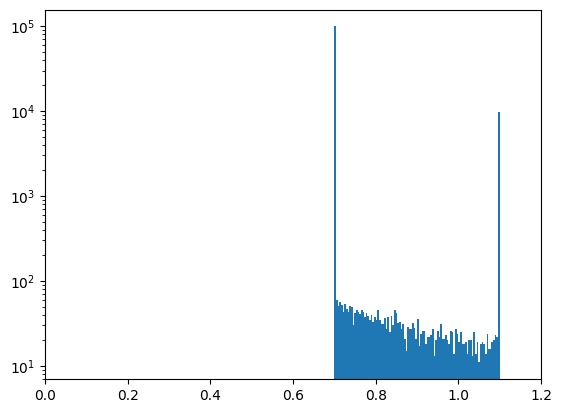

In [62]:
plt.hist(np.clip(aperture_size, .7, 1.1), bins=100)
plt.xlim(0, 1.2)
plt.yscale('log')
plt.show()

In [63]:
ctx = get_context("spawn")
size = 64

tasks = [
    (
        filter,
        location,
        field,
        ra_reference,
        dec_reference,
        size,
        maxlag[filter],
        fluxes['aperture_size'] / pixel_scale_rubin,
        psfs[filter],
        noise_squares[filter]
    )
    for filter in rubin_filters
]

with ctx.Pool(processes=min(N_cores, len(rubin_filters))) as pool:
    results = pool.map(process_rubin_filter, tasks)

for filter, flux, sigma in results:
    fluxes[f'flux_{filter}'] = flux / pixel_scale_rubin**2
    fluxes[f'flux_{filter}_sigma'] = sigma / pixel_scale_rubin**2

In [67]:
maxlag['NIR-Y']=np.int64(7)

In [68]:
maxlag

{'u': np.int64(2),
 'g': np.int64(2),
 'r': np.int64(2),
 'i': np.int64(2),
 'z': np.int64(2),
 'y': np.int64(2),
 'VIS': np.int64(2),
 'DES-G': np.int64(7),
 'DES-R': np.int64(4),
 'DES-I': np.int64(5),
 'NIR-Y': np.int64(7),
 'NIR-J': np.int64(7),
 'NIR-H': np.int64(5)}

In [69]:
euclid_size = 2 * size

ctx = get_context("spawn")

tasks = [
    (
        filter,
        location,
        field,
        ra_reference,
        dec_reference,
        euclid_size,
        maxlag[filter],
        fluxes['aperture_size'] / pixel_scale_euclid,
        noise_squares[filter],
        psfs[filter],
    )
    for filter in euclid_filters
]

with ctx.Pool(processes=min(N_cores, len(euclid_filters))) as pool:
    results = pool.starmap(process_euclid_filter, tasks)

for filter, flux, sigma in results:
    fluxes[f'flux_{filter}'] = flux / pixel_scale_euclid**2
    fluxes[f'flux_{filter}_sigma'] = sigma / pixel_scale_euclid**2

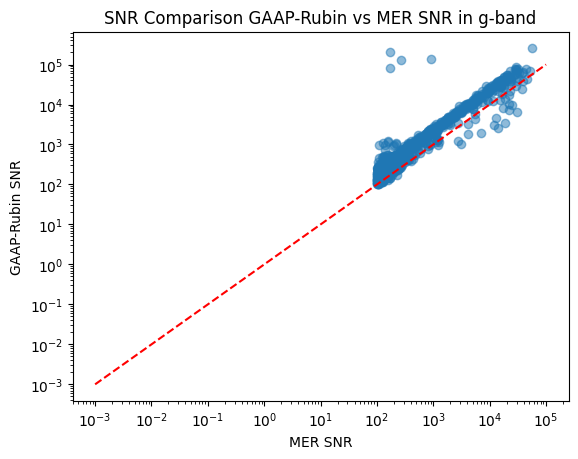

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.9545004945598418
Average SNR improvement factor (GAAP-Rubin / MER): 4.279158279399129


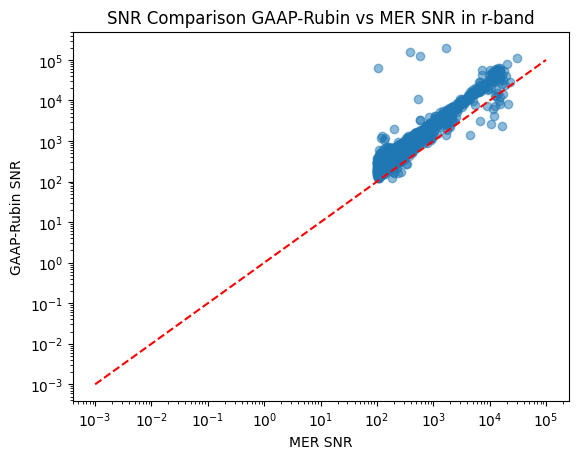

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.9852150537634409
Average SNR improvement factor (GAAP-Rubin / MER): 3.336866568337314


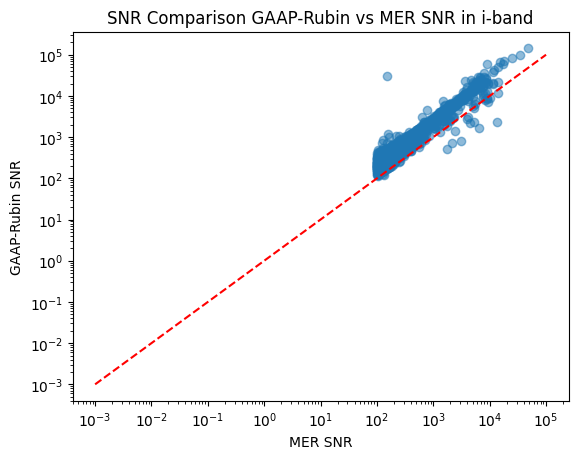

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.9876203576341128
Average SNR improvement factor (GAAP-Rubin / MER): 2.4420498053277697


In [74]:
for filter in ['g', 'r', 'i']:
    snr_meer = cat[f'FLUX_{filter.upper()}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter.upper()}_EXT_DECAM_4FWHM_APER']
    snr_gaap_rubin = fluxes[f'flux_{filter}']/fluxes[f'flux_{filter}_sigma']
    snr_gaap_rubin = fluxes[f'flux_DES-{filter.upper()}']/fluxes[f'flux_DES-{filter.upper()}_sigma']
    cutoff_snr = 100
    mask = (snr_meer > cutoff_snr) & (snr_gaap_rubin > cutoff_snr) & (np.isfinite(snr_gaap_rubin)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_rubin[mask],
                alpha=0.5)
    plt.title(f'SNR Comparison GAAP-Rubin vs MER SNR in {filter}-band')
    plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Rubin SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Rubin SNR > MER SNR:", np.nansum(snr_gaap_rubin[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_rubin[mask])))
    print("Average SNR improvement factor (GAAP-Rubin / MER):", np.nanmean(snr_gaap_rubin[mask] / snr_meer[mask]))

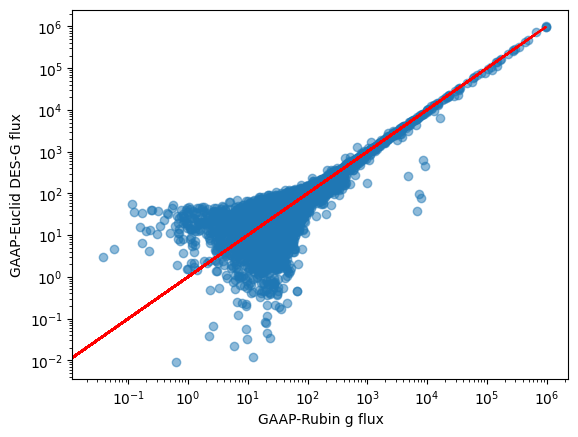

In [75]:
plt.scatter(fluxes['flux_g'], fluxes['flux_DES-G'], alpha=0.5)
plt.plot(fluxes['flux_g'], fluxes['flux_g'], 'r--')
plt.xlabel('GAAP-Rubin g flux')
plt.ylabel('GAAP-Euclid DES-G flux')
plt.loglog()
plt.show()

In [72]:
df = pd.DataFrame(fluxes)

In [76]:
df.to_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv', index=False)